# 第11章：神经网络回归

> **学习目标：**
> - 理解回归任务与分类任务的本质区别
> - 掌握神经网络回归的输出层设计
> - 从零实现 MLP 回归网络
> - 比较不同回归损失函数（MSE、MAE、Huber）
> - 完成房价预测实战项目

---

## 📚 为什么需要单独学习回归？

在前面的章节中，我们主要使用**分类任务**（如 MNIST 数字识别）来讲解神经网络。

但在实际应用中，**回归问题**同样重要：
- 🏠 房价预测
- 📈 股票价格预测
- 🌡️ 天气温度预测
- ⏱️ 时间序列预测
- 💰 销售额预测

回归和分类虽然都使用神经网络，但有一些**关键区别**需要特别注意！

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
np.random.seed(42)

print("库导入成功！")

库导入成功！


---

## 1. 回归 vs 分类：关键区别

### 1.1 对比表

| 方面 | 分类任务 | 回归任务 |
|------|---------|----------|
| **输出类型** | 离散类别（0, 1, 2...） | 连续数值（3.14, 100.5...） |
| **输出层激活** | Softmax / Sigmoid | 无激活（线性） |
| **损失函数** | 交叉熵 | MSE / MAE / Huber |
| **评估指标** | 准确率、F1、AUC | R²、RMSE、MAE |
| **输出范围** | [0, 1] 概率 | (-∞, +∞) 任意实数 |

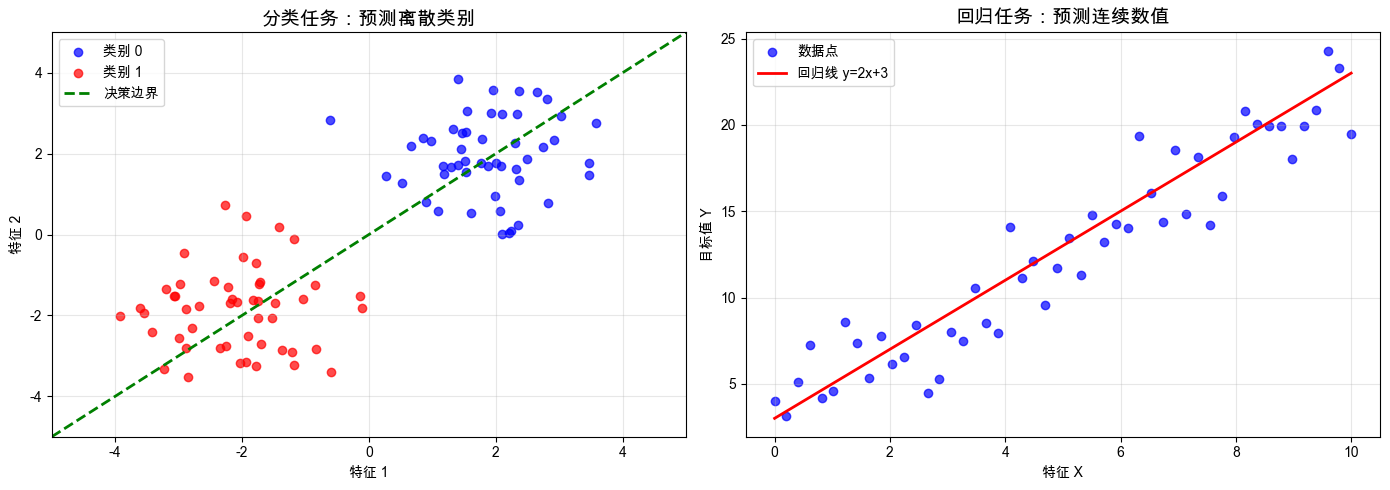


🔍 关键区别：
   • 分类：输出是'属于哪一类'的概率
   • 回归：输出是'具体是多少'的数值


In [2]:
# 可视化回归 vs 分类的区别
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===== 左图：分类任务 =====
ax1 = axes[0]
np.random.seed(42)
# 生成两类数据
X_class0 = np.random.randn(50, 2) + np.array([2, 2])
X_class1 = np.random.randn(50, 2) + np.array([-2, -2])
ax1.scatter(X_class0[:, 0], X_class0[:, 1], c='blue', label='类别 0', alpha=0.7)
ax1.scatter(X_class1[:, 0], X_class1[:, 1], c='red', label='类别 1', alpha=0.7)
# 画决策边界
ax1.axline((0, 0), slope=1, color='green', linestyle='--', linewidth=2, label='决策边界')
ax1.set_xlabel('特征 1')
ax1.set_ylabel('特征 2')
ax1.set_title('分类任务：预测离散类别', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)

# ===== 右图：回归任务 =====
ax2 = axes[1]
np.random.seed(42)
X_reg = np.linspace(0, 10, 50)
y_reg = 2 * X_reg + 3 + np.random.randn(50) * 2  # y = 2x + 3 + 噪声
ax2.scatter(X_reg, y_reg, c='blue', alpha=0.7, label='数据点')
# 画回归线
ax2.plot(X_reg, 2 * X_reg + 3, color='red', linewidth=2, label='回归线 y=2x+3')
ax2.set_xlabel('特征 X')
ax2.set_ylabel('目标值 Y')
ax2.set_title('回归任务：预测连续数值', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 关键区别：")
print("   • 分类：输出是'属于哪一类'的概率")
print("   • 回归：输出是'具体是多少'的数值")

### 1.2 网络结构对比

```
分类网络（以3分类为例）：              回归网络：
                                      
输入层 ──► 隐藏层 ──► 输出层           输入层 ──► 隐藏层 ──► 输出层
                    ↓                                      ↓
              Softmax激活                            无激活（线性）
                    ↓                                      ↓
              [0.1, 0.7, 0.2]                          [25.3]
              (概率分布)                            (连续数值)
                    ↓                                      ↓
              交叉熵损失                              MSE损失
```

In [3]:
# 代码演示：输出层的区别

print("="*60)
print("分类任务 vs 回归任务：输出层对比")
print("="*60)

# 模拟网络最后一层的输出（logits）
logits = np.array([2.0, 5.0, 1.0])

print("\n假设网络输出（logits）:", logits)

# ========== 分类任务 ==========
def softmax(z):
    """Softmax 激活函数：将 logits 转换为概率分布"""
    exp_z = np.exp(z - np.max(z))  # 减去最大值防止溢出
    return exp_z / np.sum(exp_z)

probabilities = softmax(logits)
predicted_class = np.argmax(probabilities)

print("\n📊 分类任务处理：")
print(f"   Softmax 后的概率: {probabilities}")
print(f"   预测类别: {predicted_class}（概率最大的类）")
print(f"   概率之和: {np.sum(probabilities):.4f}（必须等于1）")

# ========== 回归任务 ==========
regression_output = logits[0]  # 假设只有一个输出

print("\n📈 回归任务处理：")
print(f"   直接输出数值: {regression_output}")
print(f"   无需激活函数，输出可以是任意实数")
print(f"   如预测房价: ${regression_output * 10000:.2f}")

分类任务 vs 回归任务：输出层对比

假设网络输出（logits）: [2. 5. 1.]

📊 分类任务处理：
   Softmax 后的概率: [0.04661262 0.93623955 0.01714783]
   预测类别: 1（概率最大的类）
   概率之和: 1.0000（必须等于1）

📈 回归任务处理：
   直接输出数值: 2.0
   无需激活函数，输出可以是任意实数
   如预测房价: $20000.00


---

## 2. 回归损失函数详解

### 2.1 三种常用损失函数

| 损失函数 | 公式 | 特点 |
|---------|------|------|
| **MSE** | $\frac{1}{n}\sum(y - \hat{y})^2$ | 对大误差惩罚重，对异常值敏感 |
| **MAE** | $\frac{1}{n}\sum|y - \hat{y}|$ | 对异常值鲁棒，梯度恒定 |
| **Huber** | 混合 MSE 和 MAE | 结合两者优点 |

In [4]:
# 从零实现三种损失函数

def mse_loss(y_true, y_pred):
    """
    均方误差 (Mean Squared Error)
    
    公式: MSE = (1/n) * Σ(y_true - y_pred)^2
    
    特点：
    - 对大误差惩罚更重（误差会被平方放大）
    - 处处可微，梯度连续
    - 对异常值（outliers）非常敏感
    
    参数:
        y_true: 真实值, shape (n_samples,)
        y_pred: 预测值, shape (n_samples,)
    
    返回:
        loss: 标量，MSE损失值
    """
    # 计算预测误差
    error = y_true - y_pred
    
    # 对误差进行平方（放大大误差的影响）
    squared_error = error ** 2
    
    # 求均值
    return np.mean(squared_error)


def mae_loss(y_true, y_pred):
    """
    平均绝对误差 (Mean Absolute Error)
    
    公式: MAE = (1/n) * Σ|y_true - y_pred|
    
    特点：
    - 对异常值更鲁棒（误差不会被平方放大）
    - 在 error=0 处不可微（梯度有跳跃）
    - 梯度恒定为 ±1
    
    参数:
        y_true: 真实值, shape (n_samples,)
        y_pred: 预测值, shape (n_samples,)
    
    返回:
        loss: 标量，MAE损失值
    """
    # 计算预测误差
    error = y_true - y_pred
    
    # 取绝对值（不区分正负误差）
    absolute_error = np.abs(error)
    
    # 求均值
    return np.mean(absolute_error)


def huber_loss(y_true, y_pred, delta=1.0):
    """
    Huber 损失（平滑的 L1 损失）
    
    公式:
        当 |error| <= delta: 0.5 * error^2
        当 |error| > delta:  delta * (|error| - 0.5 * delta)
    
    特点：
    - 小误差时表现像 MSE（光滑、可微）
    - 大误差时表现像 MAE（对异常值鲁棒）
    - delta 控制两种行为的切换点
    
    参数:
        y_true: 真实值, shape (n_samples,)
        y_pred: 预测值, shape (n_samples,)
        delta: 切换阈值，默认 1.0
    
    返回:
        loss: 标量，Huber损失值
    """
    # 计算预测误差
    error = y_true - y_pred
    
    # 计算绝对误差
    abs_error = np.abs(error)
    
    # 根据误差大小选择不同的计算方式
    # 小误差：使用 MSE 的形式
    quadratic = 0.5 * error ** 2
    
    # 大误差：使用 MAE 的形式（但调整使其连续）
    linear = delta * (abs_error - 0.5 * delta)
    
    # 根据 |error| 是否超过 delta 来选择
    loss = np.where(abs_error <= delta, quadratic, linear)
    
    return np.mean(loss)


# 测试三种损失函数
y_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y_pred = np.array([1.1, 2.2, 2.8, 4.5, 4.9])

print("="*60)
print("三种损失函数对比")
print("="*60)
print(f"\n真实值: {y_true}")
print(f"预测值: {y_pred}")
print(f"误差:   {y_true - y_pred}")
print(f"\nMSE Loss:   {mse_loss(y_true, y_pred):.6f}")
print(f"MAE Loss:   {mae_loss(y_true, y_pred):.6f}")
print(f"Huber Loss: {huber_loss(y_true, y_pred):.6f}")

三种损失函数对比

真实值: [1. 2. 3. 4. 5.]
预测值: [1.1 2.2 2.8 4.5 4.9]
误差:   [-0.1 -0.2  0.2 -0.5  0.1]

MSE Loss:   0.070000
MAE Loss:   0.220000
Huber Loss: 0.035000


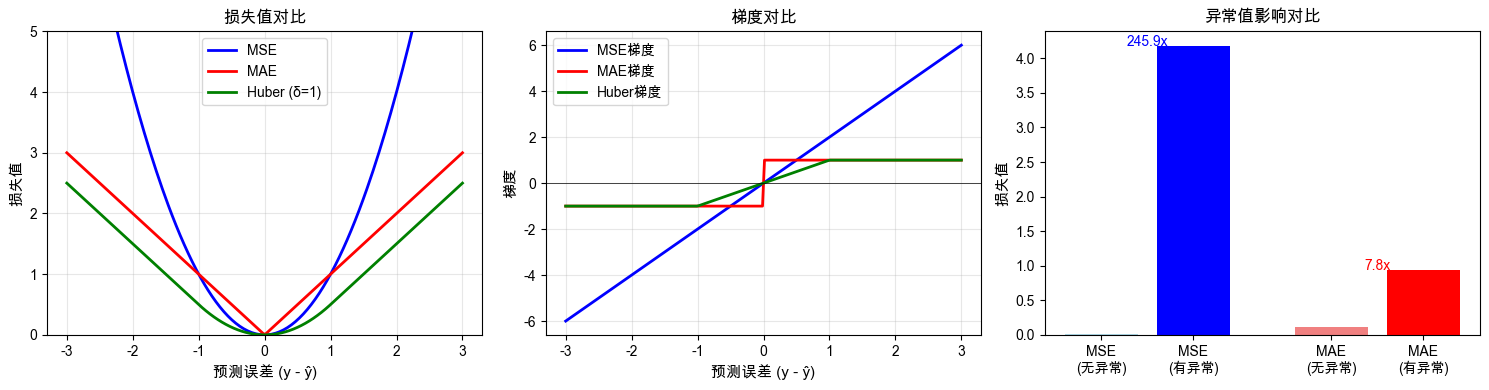


🔍 观察结论：
   • MSE: 一个异常值导致损失增加 245.9 倍！
   • MAE: 异常值影响较小，只增加 7.8 倍
   • Huber: 结合两者优点，小误差光滑，大误差鲁棒


In [5]:
# 可视化三种损失函数
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

errors = np.linspace(-3, 3, 200)

# ===== 图1：损失值对比 =====
ax1 = axes[0]
mse_values = errors ** 2
mae_values = np.abs(errors)
huber_values = np.where(np.abs(errors) <= 1, 0.5 * errors**2, np.abs(errors) - 0.5)

ax1.plot(errors, mse_values, 'b-', linewidth=2, label='MSE')
ax1.plot(errors, mae_values, 'r-', linewidth=2, label='MAE')
ax1.plot(errors, huber_values, 'g-', linewidth=2, label='Huber (δ=1)')
ax1.set_xlabel('预测误差 (y - ŷ)', fontsize=11)
ax1.set_ylabel('损失值', fontsize=11)
ax1.set_title('损失值对比', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 5)

# ===== 图2：梯度对比 =====
ax2 = axes[1]
mse_grad = 2 * errors  # d(e^2)/de = 2e
mae_grad = np.sign(errors)  # d|e|/de = sign(e)
huber_grad = np.where(np.abs(errors) <= 1, errors, np.sign(errors))

ax2.plot(errors, mse_grad, 'b-', linewidth=2, label='MSE梯度')
ax2.plot(errors, mae_grad, 'r-', linewidth=2, label='MAE梯度')
ax2.plot(errors, huber_grad, 'g-', linewidth=2, label='Huber梯度')
ax2.set_xlabel('预测误差 (y - ŷ)', fontsize=11)
ax2.set_ylabel('梯度', fontsize=11)
ax2.set_title('梯度对比', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# ===== 图3：异常值影响 =====
ax3 = axes[2]
# 模拟包含异常值的数据
normal_errors = np.array([0.1, -0.2, 0.15, -0.1, 0.05])
outlier = np.array([5.0])  # 一个大异常值
all_errors = np.concatenate([normal_errors, outlier])

# 计算各损失
mse_normal = np.mean(normal_errors**2)
mse_with_outlier = np.mean(all_errors**2)
mae_normal = np.mean(np.abs(normal_errors))
mae_with_outlier = np.mean(np.abs(all_errors))

x_pos = [0, 1, 2.5, 3.5]
heights = [mse_normal, mse_with_outlier, mae_normal, mae_with_outlier]
colors = ['lightblue', 'blue', 'lightcoral', 'red']
labels = ['MSE\n(无异常)', 'MSE\n(有异常)', 'MAE\n(无异常)', 'MAE\n(有异常)']

bars = ax3.bar(x_pos, heights, color=colors, width=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(labels)
ax3.set_ylabel('损失值', fontsize=11)
ax3.set_title('异常值影响对比', fontsize=12, fontweight='bold')

# 标注增长倍数
mse_increase = mse_with_outlier / mse_normal
mae_increase = mae_with_outlier / mae_normal
ax3.annotate(f'{mse_increase:.1f}x', xy=(0.5, mse_with_outlier), 
             ha='center', fontsize=10, fontweight='bold', color='blue')
ax3.annotate(f'{mae_increase:.1f}x', xy=(3, mae_with_outlier), 
             ha='center', fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print("\n🔍 观察结论：")
print(f"   • MSE: 一个异常值导致损失增加 {mse_increase:.1f} 倍！")
print(f"   • MAE: 异常值影响较小，只增加 {mae_increase:.1f} 倍")
print("   • Huber: 结合两者优点，小误差光滑，大误差鲁棒")

---

## 3. 从零实现 MLP 回归网络

现在让我们从零实现一个用于回归任务的多层感知机！

### 3.1 网络架构

```
输入层 (n 个特征)
    ↓
隐藏层1 (64 神经元) + ReLU
    ↓
隐藏层2 (32 神经元) + ReLU
    ↓
输出层 (1 神经元) + 无激活（线性）
    ↓
MSE 损失
```

In [ ]:
class MLPRegressor:
    """
    多层感知机回归器 - 从零实现
    
    网络结构：
    输入层 → 隐藏层1(ReLU) → 隐藏层2(ReLU) → 输出层(线性)
    
    与分类网络的关键区别：
    1. 输出层使用线性激活（无激活函数）
    2. 使用 MSE 损失函数
    3. 评估指标使用 R² 和 RMSE
    """
    
    def __init__(self, input_size, hidden1_size=64, hidden2_size=32, output_size=1):
        """
        初始化网络参数
        
        参数:
            input_size: 输入特征数量
            hidden1_size: 第一隐藏层神经元数，默认 64
            hidden2_size: 第二隐藏层神经元数，默认 32
            output_size: 输出维度，回归任务通常为 1
        """
        # ===== 使用 He 初始化（适合 ReLU 激活函数）=====
        # He 初始化：W ~ N(0, sqrt(2/n_in))
        # 这能防止梯度消失/爆炸，让网络更容易训练
        
        # 输入层 → 隐藏层1 的权重和偏置
        # W1 shape: (hidden1_size, input_size)
        self.W1 = np.random.randn(hidden1_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden1_size))  # 偏置初始化为 0
        
        # 隐藏层1 → 隐藏层2 的权重和偏置
        # W2 shape: (hidden2_size, hidden1_size)
        self.W2 = np.random.randn(hidden2_size, hidden1_size) * np.sqrt(2.0 / hidden1_size)
        self.b2 = np.zeros((1, hidden2_size))
        
        # 隐藏层2 → 输出层 的权重和偏置
        # W3 shape: (output_size, hidden2_size)
        self.W3 = np.random.randn(output_size, hidden2_size) * np.sqrt(2.0 / hidden2_size)
        self.b3 = np.zeros((1, output_size))
        
        # 保存网络结构信息
        self.layers = [input_size, hidden1_size, hidden2_size, output_size]
        
        # 用于记录训练过程
        self.train_losses = []
        self.val_losses = []
        
        print(f"网络初始化完成！")
        print(f"结构: {input_size} → {hidden1_size} → {hidden2_size} → {output_size}")
    
    def relu(self, z):
        """
        ReLU 激活函数
        
        公式: ReLU(z) = max(0, z)
        
        特点：
        - 计算简单高效
        - 缓解梯度消失问题
        - 可能导致"死亡 ReLU"（神经元永远不激活）
        """
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        """
        ReLU 的导数
        
        公式: 
            z > 0 时，导数 = 1
            z <= 0 时，导数 = 0
        """
        return (z > 0).astype(float)
    
    def forward(self, X):
        """
        前向传播
        
        计算流程：
        X → [W1, b1] → z1 → ReLU → a1
          → [W2, b2] → z2 → ReLU → a2  
          → [W3, b3] → z3 → 输出（无激活）
        
        参数:
            X: 输入数据, shape (n_samples, n_features)
        
        返回:
            output: 预测值, shape (n_samples, 1)
        """
        # 保存中间结果用于反向传播
        self.X = X
        
        # ===== 第一层 =====
        # 线性变换: z1 = X @ W1.T + b1
        self.z1 = X @ self.W1.T + self.b1  # shape: (n_samples, hidden1_size)
        # 激活函数
        self.a1 = self.relu(self.z1)        # shape: (n_samples, hidden1_size)
        
        # ===== 第二层 =====
        # 线性变换: z2 = a1 @ W2.T + b2
        self.z2 = self.a1 @ self.W2.T + self.b2  # shape: (n_samples, hidden2_size)
        # 激活函数
        self.a2 = self.relu(self.z2)             # shape: (n_samples, hidden2_size)
        
        # ===== 输出层（回归：无激活函数！）=====
        # 线性变换: z3 = a2 @ W3.T + b3
        self.z3 = self.a2 @ self.W3.T + self.b3  # shape: (n_samples, 1)
        
        # 回归任务：直接输出 z3，不需要激活函数
        # 这允许输出任意实数值
        return self.z3
    
    def mse_loss(self, y_true, y_pred):
        """
        计算 MSE 损失
        
        参数:
            y_true: 真实值, shape (n_samples, 1)
            y_pred: 预测值, shape (n_samples, 1)
        
        返回:
            loss: 标量
        """
        return np.mean((y_true - y_pred) ** 2)
    
    def backward(self, y_true, learning_rate=0.01):
        """
        反向传播 + 参数更新
        
        对于 MSE 损失和线性输出层：
        dL/dz3 = (2/n) * (y_pred - y_true)
        
        然后逐层反向传播梯度。
        
        参数:
            y_true: 真实值, shape (n_samples, 1)
            learning_rate: 学习率
        """
        n_samples = y_true.shape[0]
        
        # ===== 输出层梯度 =====
        # MSE 损失对 z3 的梯度: dL/dz3 = (2/n) * (y_pred - y_true)
        # 简化为: dL/dz3 = (y_pred - y_true) / n
        dz3 = (self.z3 - y_true) / n_samples  # shape: (n_samples, 1)
        
        # 计算 W3 和 b3 的梯度
        # dL/dW3 = dz3.T @ a2
        dW3 = dz3.T @ self.a2  # shape: (1, hidden2_size)
        db3 = np.sum(dz3, axis=0, keepdims=True)  # shape: (1, 1)
        
        # ===== 第二隐藏层梯度 =====
        # dL/da2 = dz3 @ W3
        da2 = dz3 @ self.W3  # shape: (n_samples, hidden2_size)
        # dL/dz2 = dL/da2 * ReLU'(z2)
        dz2 = da2 * self.relu_derivative(self.z2)  # shape: (n_samples, hidden2_size)
        
        # 计算 W2 和 b2 的梯度
        dW2 = dz2.T @ self.a1  # shape: (hidden2_size, hidden1_size)
        db2 = np.sum(dz2, axis=0, keepdims=True)  # shape: (1, hidden2_size)
        
        # ===== 第一隐藏层梯度 =====
        # dL/da1 = dz2 @ W2
        da1 = dz2 @ self.W2  # shape: (n_samples, hidden1_size)
        # dL/dz1 = dL/da1 * ReLU'(z1)
        dz1 = da1 * self.relu_derivative(self.z1)  # shape: (n_samples, hidden1_size)
        
        # 计算 W1 和 b1 的梯度
        dW1 = dz1.T @ self.X  # shape: (hidden1_size, input_size)
        db1 = np.sum(dz1, axis=0, keepdims=True)  # shape: (1, hidden1_size)
        
        # ===== 参数更新（梯度下降）=====
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, 
            epochs=100, learning_rate=0.01, batch_size=32, verbose=True):
        """
        训练模型
        
        参数:
            X_train: 训练特征, shape (n_samples, n_features)
            y_train: 训练标签, shape (n_samples, 1)
            X_val: 验证特征（可选）
            y_val: 验证标签（可选）
            epochs: 训练轮数
            learning_rate: 学习率
            batch_size: 批量大小
            verbose: 是否打印训练过程
        """
        n_samples = X_train.shape[0]
        self.train_losses = []
        self.val_losses = []
        
        for epoch in range(epochs):
            # 打乱数据顺序
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # 小批量梯度下降
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # 前向传播
                y_pred = self.forward(X_batch)
                
                # 反向传播和更新
                self.backward(y_batch, learning_rate)
            
            # 计算并记录损失
            train_pred = self.forward(X_train)
            train_loss = self.mse_loss(y_train, train_pred)
            self.train_losses.append(train_loss)
            
            if X_val is not None:
                val_pred = self.forward(X_val)
                val_loss = self.mse_loss(y_val, val_pred)
                self.val_losses.append(val_loss)
            
            # 打印进度
            if verbose and (epoch + 1) % 20 == 0:
                msg = f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}"
                if X_val is not None:
                    msg += f" - Val Loss: {val_loss:.4f}"
                print(msg)
    
    def predict(self, X):
        """
        预测
        
        参数:
            X: 输入特征, shape (n_samples, n_features)
        
        返回:
            predictions: 预测值, shape (n_samples, 1)
        """
        return self.forward(X)
    
    def score(self, X, y_true):
        """
        计算 R² 分数
        
        R² = 1 - SS_res / SS_tot
        其中:
        - SS_res = Σ(y_true - y_pred)² 残差平方和
        - SS_tot = Σ(y_true - y_mean)² 总平方和
        
        R² 的含义:
        - R² = 1: 完美预测
        - R² = 0: 和平均值预测一样
        - R² < 0: 比平均值预测还差
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)


print("MLPRegressor 类定义完成！")

---

## 4. 实战：加州房价预测

现在让我们用加州房价数据集来实战！

### 4.1 数据加载与探索

In [ ]:
# 加载加州房价数据集
print("="*60)
print("加州房价数据集")
print("="*60)

housing = fetch_california_housing()
X, y = housing.data, housing.target

print(f"\n📊 数据集信息:")
print(f"   样本数量: {X.shape[0]}")
print(f"   特征数量: {X.shape[1]}")
print(f"   目标: 房价中位数（单位：10万美元）")

print(f"\n📋 特征列表:")
for i, name in enumerate(housing.feature_names):
    print(f"   {i+1}. {name}")

print(f"\n🏠 房价范围: ${y.min()*100000:.0f} ~ ${y.max()*100000:.0f}")
print(f"   房价均值: ${y.mean()*100000:.0f}")

In [ ]:
# 数据可视化
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, (ax, name) in enumerate(zip(axes.flatten(), housing.feature_names)):
    ax.scatter(X[:, i], y, alpha=0.1, s=1)
    ax.set_xlabel(name)
    ax.set_ylabel('房价')
    ax.set_title(f'{name} vs 房价')

plt.suptitle('特征与房价的关系', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 数据预处理

**⚠️ 重要：回归任务中，数据标准化非常关键！**

原因：
1. 不同特征的尺度差异很大（如收入 vs 房龄）
2. 神经网络对输入尺度敏感
3. 有助于梯度下降更快收敛

In [ ]:
# 数据划分：训练集、验证集、测试集
# 先分出测试集（20%），再从剩余中分出验证集（25% of 80% = 20%）
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("数据划分:")
print(f"  训练集: {X_train.shape[0]} 样本 (60%)")
print(f"  验证集: {X_val.shape[0]} 样本 (20%)")
print(f"  测试集: {X_test.shape[0]} 样本 (20%)")

# ===== 数据标准化 =====
# 使用 StandardScaler: (x - mean) / std
# 注意：只在训练集上 fit，然后 transform 所有数据集
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)  # fit + transform
X_val_scaled = scaler_X.transform(X_val)          # 只 transform
X_test_scaled = scaler_X.transform(X_test)        # 只 transform

# 目标值也需要标准化（可选，但推荐）
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

print("\n标准化后的特征范围:")
print(f"  均值: {X_train_scaled.mean(axis=0).round(4)}")
print(f"  标准差: {X_train_scaled.std(axis=0).round(4)}")

### 4.3 模型训练

In [ ]:
# 创建并训练模型
print("="*60)
print("开始训练 MLP 回归模型")
print("="*60)

# 初始化模型
model = MLPRegressor(
    input_size=X_train_scaled.shape[1],  # 8 个特征
    hidden1_size=64,
    hidden2_size=32,
    output_size=1
)

# 训练模型
model.fit(
    X_train_scaled, y_train_scaled,
    X_val=X_val_scaled, y_val=y_val_scaled,
    epochs=200,
    learning_rate=0.01,
    batch_size=64,
    verbose=True
)

print("\n训练完成！")

In [ ]:
# 可视化训练过程
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===== 图1：学习曲线 =====
ax1 = axes[0]
epochs = range(1, len(model.train_losses) + 1)
ax1.plot(epochs, model.train_losses, 'b-', label='训练损失', linewidth=2)
ax1.plot(epochs, model.val_losses, 'r-', label='验证损失', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('MSE Loss', fontsize=11)
ax1.set_title('学习曲线', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ===== 图2：预测 vs 真实 =====
ax2 = axes[1]
# 在测试集上预测
y_pred_scaled = model.predict(X_test_scaled)
# 反标准化得到真实房价
y_pred = scaler_y.inverse_transform(y_pred_scaled)

ax2.scatter(y_test, y_pred, alpha=0.3, s=10)
# 画对角线（完美预测线）
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='完美预测')
ax2.set_xlabel('真实房价', fontsize=11)
ax2.set_ylabel('预测房价', fontsize=11)
ax2.set_title('预测值 vs 真实值', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 评估模型
print("="*60)
print("模型评估")
print("="*60)

# 计算各种评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 测试集评估指标:")
print(f"   MSE (均方误差):     {mse:.4f}")
print(f"   RMSE (均方根误差):  {rmse:.4f}")
print(f"   MAE (平均绝对误差): {mae:.4f}")
print(f"   R² (决定系数):      {r2:.4f}")

print(f"\n💡 解读:")
print(f"   • RMSE = {rmse:.4f} 意味着预测误差约 ${rmse*100000:.0f}")
print(f"   • R² = {r2:.4f} 意味着模型解释了 {r2*100:.1f}% 的房价变异")

---

## 5. 与 sklearn 对比

让我们用 sklearn 的 MLPRegressor 来对比我们的实现！

In [ ]:
from sklearn.neural_network import MLPRegressor as SklearnMLPRegressor

print("="*60)
print("sklearn MLPRegressor 对比")
print("="*60)

# 创建 sklearn 模型
sklearn_model = SklearnMLPRegressor(
    hidden_layer_sizes=(64, 32),  # 与我们的模型相同的结构
    activation='relu',
    solver='adam',
    learning_rate_init=0.01,
    max_iter=200,
    random_state=42,
    verbose=False
)

# 训练
sklearn_model.fit(X_train_scaled, y_train_scaled.ravel())

# 预测
sklearn_pred_scaled = sklearn_model.predict(X_test_scaled).reshape(-1, 1)
sklearn_pred = scaler_y.inverse_transform(sklearn_pred_scaled)

# 评估
sklearn_r2 = r2_score(y_test, sklearn_pred)
sklearn_rmse = np.sqrt(mean_squared_error(y_test, sklearn_pred))

print(f"\n📊 结果对比:")
print(f"{'指标':<15} {'我们的实现':<15} {'sklearn':<15}")
print("-" * 45)
print(f"{'R²':<15} {r2:<15.4f} {sklearn_r2:<15.4f}")
print(f"{'RMSE':<15} {rmse:<15.4f} {sklearn_rmse:<15.4f}")

print(f"\n💡 sklearn 使用了 Adam 优化器和更多高级技术，所以可能表现更好")

---

## 6. 损失函数对比实验

让我们比较 MSE、MAE、Huber 三种损失函数在有异常值数据上的表现！

In [ ]:
# 创建带有异常值的数据集
np.random.seed(42)

# 生成正常数据
n_samples = 200
X_demo = np.random.randn(n_samples, 1) * 2
y_demo = 3 * X_demo + 2 + np.random.randn(n_samples, 1) * 0.5  # y = 3x + 2 + 噪声

# 添加异常值（10% 的数据）
n_outliers = 20
outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
y_demo[outlier_indices] += np.random.randn(n_outliers, 1) * 10  # 大幅偏离

# 可视化数据
plt.figure(figsize=(10, 5))
normal_mask = np.ones(n_samples, dtype=bool)
normal_mask[outlier_indices] = False

plt.scatter(X_demo[normal_mask], y_demo[normal_mask], c='blue', alpha=0.6, label='正常数据')
plt.scatter(X_demo[~normal_mask], y_demo[~normal_mask], c='red', s=100, marker='x', label='异常值')
plt.xlabel('X')
plt.ylabel('y')
plt.title('带有异常值的回归数据', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"数据集: {n_samples} 个样本，其中 {n_outliers} 个异常值")

In [ ]:
# 使用 sklearn 训练三个模型（不同的损失函数需要自己实现，这里简化演示）
# 由于 sklearn 的 MLPRegressor 只支持 MSE，我们用线性回归来演示损失函数的区别

from sklearn.linear_model import LinearRegression, HuberRegressor

# 训练三个模型
lr_mse = LinearRegression()  # 等效于 MSE 损失
lr_huber = HuberRegressor()  # Huber 损失

lr_mse.fit(X_demo, y_demo.ravel())
lr_huber.fit(X_demo, y_demo.ravel())

# 预测
X_line = np.linspace(-5, 5, 100).reshape(-1, 1)
y_mse = lr_mse.predict(X_line)
y_huber = lr_huber.predict(X_line)

# 真实的拟合线（无异常值时应该是 y = 3x + 2）
y_true = 3 * X_line + 2

# 可视化对比
plt.figure(figsize=(12, 5))

plt.scatter(X_demo[normal_mask], y_demo[normal_mask], c='blue', alpha=0.4, label='正常数据')
plt.scatter(X_demo[~normal_mask], y_demo[~normal_mask], c='red', s=100, marker='x', label='异常值')

plt.plot(X_line, y_true, 'g-', linewidth=2, label='真实关系 (y=3x+2)')
plt.plot(X_line, y_mse, 'b--', linewidth=2, label=f'MSE 拟合 (斜率={lr_mse.coef_[0]:.2f})')
plt.plot(X_line, y_huber, 'r--', linewidth=2, label=f'Huber 拟合 (斜率={lr_huber.coef_[0]:.2f})')

plt.xlabel('X', fontsize=11)
plt.ylabel('y', fontsize=11)
plt.title('MSE vs Huber 损失函数对比（有异常值）', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n🔍 观察结论:")
print(f"   • 真实斜率: 3.00")
print(f"   • MSE 拟合斜率: {lr_mse.coef_[0]:.2f} (被异常值拉偏)")
print(f"   • Huber 拟合斜率: {lr_huber.coef_[0]:.2f} (更接近真实值)")
print(f"   → Huber 损失对异常值更鲁棒！")

---

## 7. 本章总结

### 关键要点

1. **回归 vs 分类的区别**
   - 输出层：无激活函数（线性）
   - 损失函数：MSE/MAE/Huber 而非交叉熵
   - 评估指标：R²/RMSE/MAE 而非准确率

2. **损失函数选择**
   - MSE：对大误差敏感，收敛快
   - MAE：对异常值鲁棒
   - Huber：结合两者优点

3. **数据预处理**
   - 标准化特征和目标值非常重要
   - 只在训练集上 fit，然后 transform 所有数据

4. **评估指标解读**
   - R² = 1 完美，R² = 0 等于均值预测
   - RMSE 具有与目标相同的单位

---

## 8. 练习题

### 练习1：实现 MAE 损失的反向传播
修改 `MLPRegressor` 类，使其支持 MAE 损失函数。

### 练习2：超参数调优
尝试不同的隐藏层大小和学习率，找到最佳配置。

### 练习3：多输出回归
修改网络，同时预测多个目标（如房价和房龄）。

---

**下一步：** 完成 `exercise_05_regression.py` 练习文件！